# 라이브러리 버전 확인

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import konlpy

print(tf.__version__)
print(np.__version__)
print(konlpy.__version__)

2.6.0
1.21.4
0.5.2


# step 1. SentencePiece 설치하기

In [2]:
!pip install sentencepiece

# step 2. SentencePiece 모델 학습

In [3]:
import os
path_to_file = os.getenv('HOME')+'/aiffel/sp_tokenizer/data/korean-english-park.train.ko'

with open(path_to_file, "r") as f:
    raw = f.read().splitlines()

print("Data Size:", len(raw))

print("Example:")
for sen in raw[0:100][::20]: print(">>", sen)

Data Size: 94123
Example:
>> 개인용 컴퓨터 사용의 상당 부분은 "이것보다 뛰어날 수 있느냐?"
>> 북한의 핵무기 계획을 포기하도록 하려는 압력이 거세지고 있는 가운데, 일본과 북한의 외교관들이 외교 관계를 정상화하려는 회담을 재개했다.
>> "경호 로보트가 침입자나 화재를 탐지하기 위해서 개인적으로, 그리고 전문적으로 사용되고 있습니다."
>> 수자원부 당국은 논란이 되고 있고, 막대한 비용이 드는 이 사업에 대해 내년에 건설을 시작할 계획이다.
>> 또한 근력 운동은 활발하게 걷는 것이나 최소한 20분 동안 뛰는 것과 같은 유산소 활동에서 얻는 운동 효과를 심장과 폐에 주지 않기 때문에, 연구학자들은 근력 운동이 심장에 큰 영향을 미치는지 여부에 대해 논쟁을 해왔다.


In [4]:
max_len = 150
min_len = 10

# 중복 제거
cleaned_corpus = list(set(raw))

# 길이 조건에 맞는 문장만 선택합니다.
filtered_corpus = [s for s in cleaned_corpus if (len(s) < max_len) & (len(s) >= min_len)]

In [5]:
def tokenize(corpus):  # corpus: Tokenized Sentence's List
    tokenizer = tf.keras.preprocessing.text.Tokenizer(filters='')
    tokenizer.fit_on_texts(corpus)

    tensor = tokenizer.texts_to_sequences(corpus)

    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post')

    return tensor, tokenizer

In [6]:
import sentencepiece as spm
import os
temp_file = os.getenv('HOME')+'/aiffel/sp_tokenizer/data/korean-english-park.train.ko.temp'

vocab_size = 8000

with open(temp_file, 'w') as f:
    for row in filtered_corpus:   # 이전에 나왔던 정제했던 corpus를 활용해서 진행해야 합니다.
        f.write(str(row) + '\n')

spm.SentencePieceTrainer.Train(
    '--input={} --model_prefix=korean_spm --vocab_size={}'.format(temp_file, vocab_size)    
)
#위 Train에서  --model_type = unigram이 디폴트 적용되어 있습니다. --model_type = bpe로 옵션을 주어 변경할 수 있습니다.


sentencepiece_trainer.cc(177) LOG(INFO) Running command: --input=/aiffel/aiffel/sp_tokenizer/data/korean-english-park.train.ko.temp --model_prefix=korean_spm --vocab_size=8000
sentencepiece_trainer.cc(77) LOG(INFO) Starts training with : 
trainer_spec {
  input: /aiffel/aiffel/sp_tokenizer/data/korean-english-park.train.ko.temp
  input_format: 
  model_prefix: korean_spm
  model_type: UNIGRAM
  vocab_size: 8000
  self_test_sample_size: 0
  character_coverage: 0.9995
  input_sentence_size: 0
  shuffle_input_sentence: 1
  seed_sentencepiece_size: 1000000
  shrinking_factor: 0.75
  max_sentence_length: 4192
  num_threads: 16
  num_sub_iterations: 2
  max_sentencepiece_length: 16
  split_by_unicode_script: 1
  split_by_number: 1
  split_by_whitespace: 1
  split_digits: 0
  treat_whitespace_as_suffix: 0
  allow_whitespace_only_pieces: 0
  required_chars: 
  byte_fallback: 0
  vocabulary_output_piece_score: 1
  train_extremely_large_corpus: 0
  hard_vocab_limit: 1
  use_all_vocab: 0
  unk_id

In [7]:
!ls -l korean_spm*

-rw-r--r-- 1 root root 376816 Dec 27 06:59 korean_spm.model
-rw-r--r-- 1 root root 146213 Dec 27 06:59 korean_spm.vocab


In [8]:
s = spm.SentencePieceProcessor()
s.Load('korean_spm.model')

# SentencePiece를 활용한 sentence -> encoding
tokensIDs = s.EncodeAsIds('아버지가방에들어가신다.')
print(tokensIDs)

# SentencePiece를 활용한 sentence -> encoded pieces
print(s.SampleEncodeAsPieces('아버지가방에들어가신다.',1, 0.0))

# SentencePiece를 활용한 encoding -> sentence 복원
print(s.DecodeIds(tokensIDs))

[1243, 11, 302, 7, 3608, 11, 287, 38, 3]
['▁아버지', '가', '방', '에', '들어', '가', '신', '다', '.']
아버지가방에들어가신다.


# step 3. Tokenizer 함수 작성

In [9]:
def sp_tokenize(s, corpus): 

    tensor = []

    for sen in corpus:
        tensor.append(s.EncodeAsIds(sen))

    with open("./korean_spm.vocab", 'r') as f:
        vocab = f.readlines()

    word_index = {}
    index_word = {}

    for idx, line in enumerate(vocab):
        word = line.split("\t")[0]

        word_index.update({word:idx})
        index_word.update({idx:word})

    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post')

    return tensor, word_index, index_word

# step 4. 네이버 영화리뷰 감정 분석 문제에 SentencePiece 적용해 보기

## 데이터 준비 및 로드

In [10]:
import os

train_file = os.getenv("HOME") + "/aiffel/sentiment_classification/ratings_train.txt"
test_file = os.getenv("HOME") + "/aiffel/sentiment_classification/ratings_test.txt"

In [11]:
import pandas as pd

train_data = pd.read_table(train_file)
test_data = pd.read_table(test_file)

In [12]:
train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


In [13]:
test_data.head()

,id,document,label
0,6270596,굳 ㅋ,1
1,9274899,GDNTOPCLASSINTHECLUB,0
2,8544678,뭐야 이 평점들은.... 나쁘진 않지만 10점 짜리는 더더욱 아니잖아,0
3,6825595,지루하지는 않은데 완전 막장임... 돈주고 보기에는....,0
4,6723715,3D만 아니었어도 별 다섯 개 줬을텐데.. 왜 3D로 나와서 제 심기를 불편하게 하죠??,0


In [14]:
print(len(train_data), len(test_data))

150000 50000


train_data: 15만개, test_data: 5만개 데이터가 있음을 확인

## 중복치 확인 및 제거

데이터에 중복치가 있는지 확인하고 있는 경우 제외를 한다.

In [15]:
train_data["document"].duplicated().sum()

3817

약 3817개의 중복데이터가 있음을 확인하였다.

In [16]:
train_data = train_data.drop_duplicates(subset=['document'])

In [17]:
print(len(train_data))

146183


## 대소문자 합침

영어 대소문자가 있다면 큰 의미가 있을것 같지 않으니 다 소문자화 시켜줌.

In [18]:
train_data["_document"] = train_data["document"].apply(lambda s: str(s).lower())

## 문장 길이 선택

In [19]:
train_data["num_letter"] = train_data["document"].apply(lambda s: len(str(s)))

In [20]:
train_data["num_letter"].describe()

count    146183.000000
mean         35.981113
std          29.491258
min           1.000000
25%          16.000000
50%          27.000000
75%          43.000000
max         146.000000
Name: num_letter, dtype: float64

In [21]:
max_len = 146

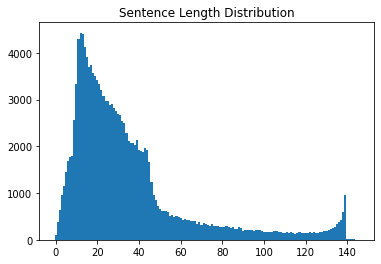

In [22]:
sentence_length = np.zeros((max_len,))
for sen in train_data["_document"]:   # 중복이 제거된 코퍼스 기준
    sentence_length[len(sen)-1] += 1

plt.bar(range(max_len), sentence_length, width=1.0)
plt.title("Sentence Length Distribution")
plt.show()

위 그림과 describe 수치 통계를 기반으로 max_len을 50으로 정하고 자름

In [23]:
max_len = 50

In [24]:
train_data["_document"] = train_data["_document"].apply(lambda s: s[:50])

## 형태소 기반 토큰화 적용

In [25]:
from konlpy.tag import Mecab

mecab = Mecab()

In [26]:
def tokenize(corpus, num_words=8000, maxlen=max_len):
    tokenizer = tf.keras.preprocessing.text.Tokenizer(filters='', num_words=num_words)
    tokenizer.fit_on_texts(corpus)

    tensor = tokenizer.texts_to_sequences(corpus)

    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post', maxlen=maxlen)

    return tensor, tokenizer

In [27]:
from konlpy.tag import Mecab

def mecab_split(sentence):
    return mecab.morphs(sentence)

mecab_corpus = []

for sen in train_data["_document"]:
    mecab_corpus.append(mecab_split(sen))

In [28]:
mecab_tensor, mecab_tokenizer = tokenize(mecab_corpus, 8000, max_len)

print(len(mecab_tokenizer.word_index))
print(len(mecab_tensor[0]), mecab_tensor.max())

48670
50 7999


8000개의 단어 사전을 활용하는 길이 50의 mecab_tensor 생성

## sentence piece 토큰화 적용

In [29]:
import sentencepiece as spm

def sentence_piece_train(model_type, vocab_size):
    train_file = os.getenv("HOME") + "/aiffel/sentiment_classification/ratings_train.txt.temp"
    with open(train_file, 'w') as f:
        for row in train_data["_document"].to_numpy():   
            f.write(str(row) + '\n')

    spm.SentencePieceTrainer.Train(
        '--input={} --model_type={} --model_prefix=ratings_{} --vocab_size={}'.format(
            train_file, model_type, model_type, vocab_size
        )    
    )

In [30]:
vocab_size = 8000
sentence_piece_train('unigram', vocab_size)
sentence_piece_train("bpe", vocab_size)

sentencepiece_trainer.cc(177) LOG(INFO) Running command: --input=/aiffel/aiffel/sentiment_classification/ratings_train.txt.temp --model_type=unigram --model_prefix=ratings_unigram --vocab_size=8000
sentencepiece_trainer.cc(77) LOG(INFO) Starts training with : 
trainer_spec {
  input: /aiffel/aiffel/sentiment_classification/ratings_train.txt.temp
  input_format: 
  model_prefix: ratings_unigram
  model_type: UNIGRAM
  vocab_size: 8000
  self_test_sample_size: 0
  character_coverage: 0.9995
  input_sentence_size: 0
  shuffle_input_sentence: 1
  seed_sentencepiece_size: 1000000
  shrinking_factor: 0.75
  max_sentence_length: 4192
  num_threads: 16
  num_sub_iterations: 2
  max_sentencepiece_length: 16
  split_by_unicode_script: 1
  split_by_number: 1
  split_by_whitespace: 1
  split_digits: 0
  treat_whitespace_as_suffix: 0
  allow_whitespace_only_pieces: 0
  required_chars: 
  byte_fallback: 0
  vocabulary_output_piece_score: 1
  train_extremely_large_corpus: 0
  hard_vocab_limit: 1
  us

In [31]:
!ls -l ratings*

FO) Tokenizing input sentences with whitespace: 146183
trainer_interface.cc(537) LOG(INFO) Done! 297988
bpe_model_trainer.cc(167) LOG(INFO) Updating active symbols. max_freq=61032 min_freq=80
bpe_model_trainer.cc(258) LOG(INFO) Added: freq=9107 size=20 all=100751 active=9723 piece=▁하
bpe_model_trainer.cc(258) LOG(INFO) Added: freq=7076 size=40 all=104406 active=13378 piece=▁안
bpe_model_trainer.cc(258) LOG(INFO) Added: freq=5030 size=60 all=107792 active=16764 piece=▁수
bpe_model_trainer.cc(258) LOG(INFO) Added: freq=4266 size=80 all=111638 active=20610 piece=▁인
bpe_model_trainer.cc(258) LOG(INFO) Added: freq=3384 size=100 all=114830 active=23802 piece=▁같
bpe_model_trainer.cc(167) LOG(INFO) Updating active symbols. max_freq=3369 min_freq=66
bpe_model_trainer.cc(258) LOG(INFO) Added: freq=3002 size=120 all=117779 active=8651 piece=▁완
bpe_model_trainer.cc(258) LOG(INFO) Added: freq=2654 size=140 all=120012 active=10884 piece=▁저
bpe_model_trainer.cc(258) LOG(INFO) Added: freq=2353 size=160 

-rw-r--r-- 1 root root 370757 Dec 27 07:00 ratings_bpe.model
-rw-r--r-- 1 root root 115966 Dec 27 07:00 ratings_bpe.vocab
-rw-r--r-- 1 root root 317283 Dec 27 05:12 ratings.model
-rw-r--r-- 1 root root 375285 Dec 27 07:00 ratings_unigram.model
-rw-r--r-- 1 root root 144580 Dec 27 07:00 ratings_unigram.vocab
-rw-r--r-- 1 root root  84080 Dec 27 05:12 ratings.vocab


In [32]:
s_unigram = spm.SentencePieceProcessor()
s_unigram.Load("ratings_unigram.model")
s_bpe = spm.SentencePieceProcessor()
s_bpe.Load("ratings_bpe.model")

True

In [33]:
tokensIDs = s_unigram.EncodeAsIds('아버지가방에들어가신다.')
print(tokensIDs)

# SentencePiece를 활용한 sentence -> encoded pieces
print(s_unigram.SampleEncodeAsPieces('아버지가방에들어가신다.',1, 0.0))

# SentencePiece를 활용한 encoding -> sentence 복원
print(s_unigram.DecodeIds(tokensIDs))

[1474, 10, 423, 15, 1476, 10, 156, 16, 4]
['▁아버지', '가', '방', '에', '들어', '가', '신', '다', '.']
아버지가방에들어가신다.


In [34]:
tokensIDs = s_bpe.EncodeAsIds('아버지가방에들어가신다.')
print(tokensIDs)

# SentencePiece를 활용한 sentence -> encoded pieces
print(s_bpe.SampleEncodeAsPieces('아버지가방에들어가신다.',1, 0.0))

# SentencePiece를 활용한 encoding -> sentence 복원
print(s_bpe.DecodeIds(tokensIDs))

[5276, 931, 6573, 6312, 1483, 6308, 6410, 6302, 6300]
['▁아버', '지가', '방', '에', '들어', '가', '신', '다', '.']
아버지가방에들어가신다.


일반적인 문장에서는 unigram이 더  잘 작동하는 것으로 보인다.

In [35]:
tokensIDs = s_unigram.EncodeAsIds(train_data["_document"][3])
print(tokensIDs)

# SentencePiece를 활용한 sentence -> encoded pieces
print(s_unigram.SampleEncodeAsPieces(train_data["_document"][3],1, 0.0))

# SentencePiece를 활용한 encoding -> sentence 복원
print(s_unigram.DecodeIds(tokensIDs))

[1592, 12, 200, 223, 6187, 3, 5, 4345, 1202, 124, 5, 656, 270, 130]
['▁교', '도', '소', '▁이야기', '구먼', '▁', '..', '솔직히', '▁재미는', '▁없다', '..', '평점', '▁조', '정']
교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정


In [36]:
tokensIDs = s_bpe.EncodeAsIds(train_data["_document"][3])
print(tokensIDs)

# SentencePiece를 활용한 sentence -> encoded pieces
print(s_bpe.SampleEncodeAsPieces(train_data["_document"][3],1, 0.0))

# SentencePiece를 활용한 encoding -> sentence 복원
print(s_bpe.DecodeIds(tokensIDs))

[648, 6310, 6402, 280, 6399, 6782, 411, 4249, 1326, 230, 3, 912, 128, 6342]
['▁교', '도', '소', '▁이야기', '구', '먼', '▁..', '솔직히', '▁재미는', '▁없다', '..', '평점', '▁조', '정']
교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정


리뷰데이터의 경우 살짝의 차이는 있지만 뭐가 더 나은지는 잘 모르겠다.

In [37]:
def sp_tokenize(s, corpus, vocab_file, maxlen=max_len): 

    tensor = []

    for sen in corpus:
        tensor.append(s.EncodeAsIds(sen))

    with open("./" + vocab_file, 'r') as f:
        vocab = f.readlines()

    word_index = {}
    index_word = {}

    for idx, line in enumerate(vocab):
        word = line.split("\t")[0]

        word_index.update({word:idx})
        index_word.update({idx:word})

    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post', maxlen=max_len)

    return tensor, word_index, index_word

In [38]:
unigram_tensor, unigram_word_index, unigram_index_word = sp_tokenize(s_unigram, train_data["_document"], "ratings_unigram.vocab")
bpe_tensor, bpe_word_index, bpe_index_word = sp_tokenize(s_bpe, train_data["_document"], "ratings_bpe.vocab")

In [39]:
print(len(unigram_tensor[0]), len(bpe_tensor[0]))
print(unigram_tensor[0].shape, bpe_tensor[0].shape)

50 50
(50,) (50,)


## 데이터 준비

In [40]:
import random
val_len = len(train_data['_document']) // 5
label = train_data["label"].to_numpy()

# shuffled_arr = list(zip(unigram_tensor, bpe_tensor, mecab_tensor, label))
# random.Random(42).shuffle(shuffled_arr)

# unigram_tensor, bpe_tensor, mecab_tensor, label = zip(*shuffled_arr)

train_dict = {}
train_dict["unigram"] = unigram_tensor[:-val_len]
train_dict["bpe"] = bpe_tensor[:-val_len]
train_dict["mecab"] = mecab_tensor[:-val_len]
train_label = label[:-val_len]

val_dict = {}
val_dict["unigram"] = unigram_tensor[-val_len:]
val_dict["bpe"] = bpe_tensor[-val_len:]
val_dict["mecab"] = mecab_tensor[-val_len:]
val_label = label[-val_len:]

In [41]:
from tensorflow import keras
from tensorflow.keras import layers

def get_model(vocab_size=vocab_size, embed_size=16, hidden_size=64, max_len=max_len):
    input_tensor = keras.Input((max_len,))
    x = layers.Embedding(vocab_size, embed_size)(input_tensor)
    x = layers.LSTM(hidden_size)(x)
    x = layers.Dense(1, activation="sigmoid")(x)
    
    model = keras.Model(input_tensor, x)
    return model

In [52]:
def train_model(tokenizer_name, history_dict):
    model = get_model()
    model_name = tokenizer_name + ".h5"
    print(model_name)
    callbacks = [
        keras.callbacks.ModelCheckpoint(model_name, 
                                        monitor="val_loss",
                                        save_best_only=True)
    ]
    model.compile(optimizer="adam", 
                  loss="binary_crossentropy", 
                  metrics=["accuracy"])
    # print(train_dict[tokenizer_name][0])
    history_dict[tokenizer_name] = model.fit(train_dict[tokenizer_name], train_label, 
                                            epochs=10, batch_size=64,
                                            callbacks=callbacks, 
                                            validation_data=(val_dict[tokenizer_name], val_label))

In [53]:
tokenizers = ["unigram", "bpe", "mecab"]
history_dict = {}
for tokenizer in tokenizers:
    train_model(tokenizer, history_dict)

unigram.h5
Epoch 1/10
1828/1828 [==============================] - 11s 5ms/step - loss: 0.4634 - accuracy: 0.7646 - val_loss: 0.3774 - val_accuracy: 0.8386
Epoch 2/10
1828/1828 [==============================] - 9s 5ms/step - loss: 0.3493 - accuracy: 0.8467 - val_loss: 0.3584 - val_accuracy: 0.8405
Epoch 3/10
1828/1828 [==============================] - 9s 5ms/step - loss: 0.3220 - accuracy: 0.8598 - val_loss: 0.3503 - val_accuracy: 0.8455
Epoch 4/10
1828/1828 [==============================] - 9s 5ms/step - loss: 0.2958 - accuracy: 0.8710 - val_loss: 0.3469 - val_accuracy: 0.8478
Epoch 5/10
1828/1828 [==============================] - 9s 5ms/step - loss: 0.2704 - accuracy: 0.8838 - val_loss: 0.3776 - val_accuracy: 0.8463
Epoch 6/10
1828/1828 [==============================] - 9s 5ms/step - loss: 0.2496 - accuracy: 0.8940 - val_loss: 0.3802 - val_accuracy: 0.8446
Epoch 7/10
1828/1828 [==============================] - 10s 5ms/step - loss: 0.2302 - accuracy: 0.9061 - val_loss: 0.3766 - 

## 테스트 데이터와 비교

In [97]:
test_input = test_data["document"].apply(lambda s: str(s).lower()[:max_len])

test_label = test_data["label"].to_numpy()
test_unigram_tensor = []
test_bpe_tensor = []
test_mecab_tensor = []

# test_mecab_tensor = mecab_split(test_input)

for sen in test_input:
    test_unigram_tensor.append(s_unigram.EncodeAsIds(sen))
    test_bpe_tensor.append(s_bpe.EncodeAsIds(sen))
    test_mecab_tensor.append(mecab_split(sen))
    
test_unigram_tensor = tf.keras.preprocessing.sequence.pad_sequences(test_unigram_tensor, padding='post', maxlen=max_len)
test_bpe_tensor = tf.keras.preprocessing.sequence.pad_sequences(test_bpe_tensor, padding='post', maxlen=max_len)
test_mecab_tensor = mecab_tokenizer.texts_to_sequences(test_mecab_tensor)
test_mecab_tensor = tf.keras.preprocessing.sequence.pad_sequences(test_mecab_tensor, padding='post', maxlen=max_len)

test_tensor = {
    "unigram": test_unigram_tensor,
    "bpe": test_bpe_tensor,
    "mecab": test_mecab_tensor,
}
print(len(test_unigram_tensor), len(test_bpe_tensor), len(test_label), max_len)

50000 50000 50000 50


In [99]:
tokenizers = ["unigram", "bpe", "mecab"]
for tokenizer in tokenizers:
    model = keras.models.load_model(tokenizer + ".h5")
    metric = model.evaluate(test_tensor[tokenizer], test_label)
    print(f"{tokenizer} accuracy: {metric[1]}")

1563/1563 [==============================] - 5s 3ms/step - loss: 0.3566 - accuracy: 0.8458
unigram accuracy: 0.8457599878311157
1563/1563 [==============================] - 4s 3ms/step - loss: 0.3565 - accuracy: 0.8444
bpe accuracy: 0.8444200158119202
1563/1563 [==============================] - 5s 3ms/step - loss: 0.3534 - accuracy: 0.8453
mecab accuracy: 0.8453400135040283


세개의 모델이 유의미한 차이는 보이지 않는것 같다.

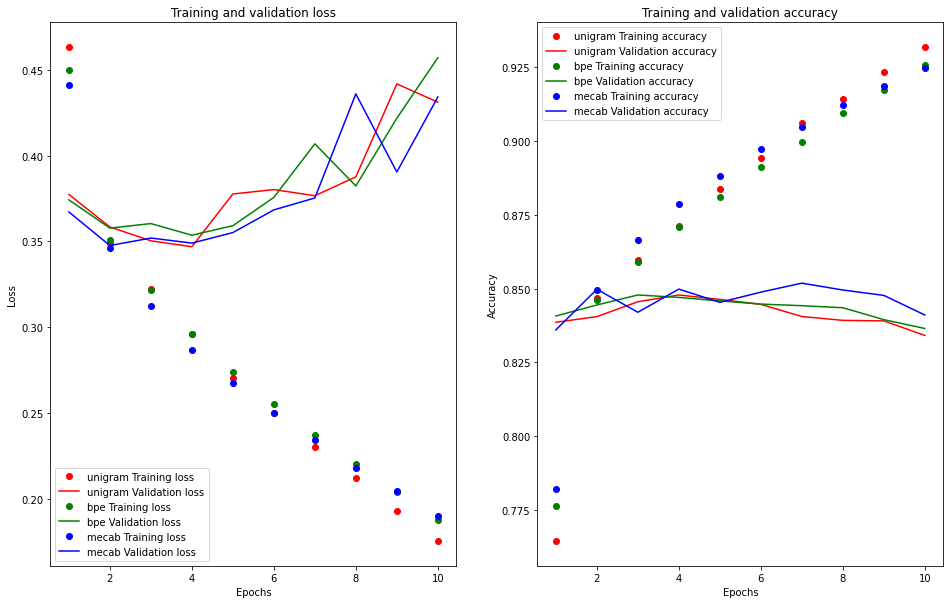

In [100]:
colors = ['r', 'g', 'b']

plt.figure(figsize=(16, 10))
plt.subplot(121)

for idx in range(len(tokenizers)):
    key = tokenizers[idx]
    history = history_dict[key].history
    color = colors[idx]
    
    loss = history['loss']
    val_loss = history['val_loss']

    epochs = range(1, len(acc) + 1)

    # "bo"는 "파란색 점"입니다
    plt.plot(epochs, loss, color + 'o', label=key + ' Training loss')
    # b는 "파란 실선"입니다
    plt.plot(epochs, val_loss, color, label=key + ' Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    
plt.legend()
    
plt.subplot(122)
for idx in range(len(tokenizers)):
    key = tokenizers[idx]
    history = history_dict[key].history
    color = colors[idx]
    
    loss = history['accuracy']
    val_loss = history['val_accuracy']

    epochs = range(1, len(acc) + 1)

    # "bo"는 "파란색 점"입니다
    plt.plot(epochs, loss, color + 'o', label=key + ' Training accuracy')
    # b는 "파란 실선"입니다
    plt.plot(epochs, val_loss, color, label=key + ' Validation accuracy')
    plt.title('Training and validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')

plt.legend()

mecab, setencepiece bpe, setencepiece unigram 세가지 모델에 대해 loss 와 accuracy를 측정해보았다.

test accuracy와 마찬가지로 해당 데이터셋에서는 크게 유의미한 차이를 보이지는 않는것 처럼 보인다.

모두 4 epoch이후에는 과적합현상이 나타난것으로 보인다.



# 회고

동일한 전처리를 적용했을 때 의미를 담은 토큰화인 mecab방법과 통계적인 이론을 적용한 방법인 wordpiece model간의 큰 차이가 없음을 확인하였다.

조사들을 없애는 전처리를 조금했더라면 결과가 더 좋지 않았을까 싶긴하지만 비교적 사전지식이 필요없는 wordpiece model이 참 유용하다라는 생각이 들었다.
